In [33]:
from tonic.datasets.nmnist import NMNIST
from torch import nn
from torch.nn import functional as F
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import math
import numpy as np


root_dir = './nmnist'
_ = NMNIST(save_to=root_dir, train=True)
_ = NMNIST(save_to=root_dir, train=False)

In [2]:
from tonic.transforms import ToFrame
from tonic.datasets import nmnist

batch_size = 4
num_workers = 4
device = "cuda:0"
shuffle = True

# Transform that accumulates events into single frame image
to_frame = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=1)

train_dataset = NMNIST(save_to=root_dir, train=True, transform=to_frame)
test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_frame)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=shuffle)

In [3]:
model_linear = nn.Sequential(
    # [2, 34, 34] -> [10]
    nn.Linear(2 * 34 * 34, 10),
    nn.ReLU(),
)

In [4]:
model_conv_linear = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9248, 10, bias=False),
    nn.ReLU()
)

In [5]:
model_conv_avg_linear = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(9248, 10, bias=False),
    nn.ReLU()
)

In [6]:
model_sinabs = nn.Sequential(
    # [2, 34, 34] -> [8, 17, 17]
    nn.Conv2d(in_channels=2, out_channels=8, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2, 2),
    
    # [8, 17, 17] -> [16, 8, 8]
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3,3), padding=(1,1), bias=False),
    nn.ReLU(),
    nn.AvgPool2d(2,2),
    
    # [16, 8, 8] -> [16, 4, 4]
    nn.Conv2d(in_channels=16, out_channels=16, kernel_size = (3,3), padding=(1,1), stride=(2,2), bias=False),
    nn.ReLU(),
    
    # [16 * 4 * 4] -> [10]
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 10, bias=False),
    nn.ReLU()
)

In [7]:
model = model_sinabs

epochs = 10
lr = 1e-3

# init the model weights
for layer in model.modules():
    if isinstance(layer, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_normal_(layer.weight.data)

optimizer = SGD(params=model.parameters(), lr=lr)
scriterion = CrossEntropyLoss()
model.to(device)

for e in range(epochs):

    # train
    train_p_bar = tqdm(train_dataloader, desc=f'Epoch {e+1}/{epochs}', leave=False, mininterval=1)
    for data, label in train_p_bar:
        # remove the time-step axis since we are training model
        # move the data to accelerator
        data = data.squeeze(dim=1).to(dtype=torch.float, device=device)
        label = label.to(dtype=torch.long, device=device)
        # forward
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        # backward
        loss.backward()
        optimizer.step()
        # set progressing bar
        #train_p_bar.set_postfix(loss=round(loss.item(), 4), mininterval=1)

    # validate
    correct_predictions = []
    with torch.no_grad():
        test_p_bar = tqdm(test_dataloader, desc=f'Epoch {e}, testing model.', mininterval=1)
        for data, label in test_p_bar:
            # remove the time-step axis since we are training model
            # move the data to accelerator
            data = data.squeeze(dim=1).to(dtype=torch.float, device=device)
            label = label.to(dtype=torch.long, device=device)
            # forward
            output = model(data)
            # calculate accuracy
            pred = output.argmax(dim=1, keepdim=True)
            # compute the total correct predictions
            correct_predictions.append(pred.eq(label.view_as(pred)))
    
        correct_predictions = torch.cat(correct_predictions)
        print(f"\nEpoch {e} - accuracy: {correct_predictions.sum().item()/(len(correct_predictions))*100}%")
        

Epoch 1/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 1/10:   2%|▏         | 339/15000 [00:01<00:43, 338.98it/s]

Epoch 1/10:   8%|▊         | 1167/15000 [00:02<00:22, 626.46it/s]

Epoch 1/10:  14%|█▍        | 2075/15000 [00:03<00:17, 754.86it/s]

Epoch 1/10:  20%|█▉        | 2983/15000 [00:04<00:14, 815.13it/s]

Epoch 1/10:  26%|██▌       | 3859/15000 [00:05<00:13, 836.98it/s]

Epoch 1/10:  32%|███▏      | 4732/15000 [00:06<00:12, 849.02it/s]

Epoch 1/10:  37%|███▋      | 5624/15000 [00:07<00:10, 863.01it/s]

Epoch 1/10:  43%|████▎     | 6505/15000 [00:08<00:09, 868.68it/s]

Epoch 1/10:  49%|████▉     | 7392/15000 [00:09<00:08, 874.33it/s]

Epoch 1/10:  55%|█████▌    | 8267/15000 [00:10<00:07, 872.92it/s]

Epoch 1/10:  61%|██████    | 9140/15000 [00:11<00:06, 868.48it/s]

Epoch 1/10:  67%|██████▋   | 10009/15000 [00:12<00:05, 866.80it/s]

Epoch 1/10:  73%|███████▎  | 10876/15000 [00:13<00:04, 853.83it/s]

Epoch 1/10:  78%|███████▊  | 11733/15000 [00:14<00:03, 854.22it/s]

Epoch 1/10:  84%|████████▍ | 12597/15000 [00:15<00:02, 857.07it/s]

Epoch 1/10:  90%|████████▉ | 13487/15000 [00:16<00:01, 866.88it/s]

Epoch 1/10:  96%|█████████▌| 14355/15000 [00:17<00:00, 862.73it/s]

Epoch 0, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 0, testing model.:  44%|████▍     | 1097/2500 [00:01<00:01, 1096.50it/s]

Epoch 0, testing model.:  88%|████████▊ | 2194/2500 [00:02<00:00, 997.01it/s] 

Epoch 0, testing model.: 100%|██████████| 2500/2500 [00:02<00:00, 1010.54it/s]


Epoch 0 - accuracy: 79.53%


Epoch 2/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 2/10:   6%|▌         | 845/15000 [00:01<00:16, 844.75it/s]

Epoch 2/10:  11%|█▏        | 1721/15000 [00:02<00:15, 862.62it/s]

Epoch 2/10:  17%|█▋        | 2598/15000 [00:03<00:14, 868.81it/s]

Epoch 2/10:  23%|██▎       | 3520/15000 [00:04<00:12, 889.56it/s]

Epoch 2/10:  29%|██▉       | 4410/15000 [00:05<00:11, 883.50it/s]

Epoch 2/10:  36%|███▌      | 5339/15000 [00:06<00:10, 898.60it/s]

Epoch 2/10:  42%|████▏     | 6268/15000 [00:07<00:09, 908.33it/s]

Epoch 2/10:  48%|████▊     | 7177/15000 [00:08<00:08, 901.59it/s]

Epoch 2/10:  54%|█████▍    | 8079/15000 [00:09<00:07, 872.08it/s]

Epoch 2/10:  60%|█████▉    | 8954/15000 [00:10<00:06, 867.34it/s]

Epoch 2/10:  66%|██████▌   | 9868/15000 [00:11<00:05, 881.03it/s]

Epoch 2/10:  72%|███████▏  | 10777/15000 [00:12<00:04, 889.24it/s]

Epoch 2/10:  78%|███████▊  | 11668/15000 [00:13<00:03, 861.16it/s]

Epoch 2/10:  84%|████████▎ | 12532/15000 [00:14<00:02, 855.65it/s]

Epoch 2/10:  90%|████████▉ | 13443/15000 [00:15<00:01, 871.87it/s]

Epoch 2/10:  95%|█████████▌| 14317/15000 [00:16<00:00, 849.16it/s]

Epoch 1, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1, testing model.:  52%|█████▏    | 1297/2500 [00:01<00:00, 1296.15it/s]

Epoch 1, testing model.: 100%|██████████| 2500/2500 [00:01<00:00, 1258.38it/s]


Epoch 1 - accuracy: 81.06%


Epoch 3/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 3/10:   5%|▌         | 795/15000 [00:01<00:17, 793.69it/s]

Epoch 3/10:  11%|█         | 1594/15000 [00:02<00:16, 796.57it/s]

Epoch 3/10:  17%|█▋        | 2487/15000 [00:03<00:14, 840.50it/s]

Epoch 3/10:  22%|██▏       | 3361/15000 [00:04<00:13, 853.66it/s]

Epoch 3/10:  28%|██▊       | 4272/15000 [00:05<00:12, 874.21it/s]

Epoch 3/10:  34%|███▍      | 5147/15000 [00:06<00:11, 874.18it/s]

Epoch 3/10:  40%|████      | 6059/15000 [00:07<00:10, 886.28it/s]

Epoch 3/10:  46%|████▋     | 6951/15000 [00:08<00:09, 888.07it/s]

Epoch 3/10:  52%|█████▏    | 7840/15000 [00:09<00:08, 883.76it/s]

Epoch 3/10:  58%|█████▊    | 8758/15000 [00:10<00:06, 894.20it/s]

Epoch 3/10:  64%|██████▍   | 9653/15000 [00:11<00:06, 879.98it/s]

Epoch 3/10:  70%|███████   | 10567/15000 [00:12<00:04, 890.01it/s]

Epoch 3/10:  77%|███████▋  | 11514/15000 [00:13<00:03, 907.11it/s]

Epoch 3/10:  83%|████████▎ | 12422/15000 [00:14<00:02, 896.82it/s]

Epoch 3/10:  89%|████████▉ | 13320/15000 [00:15<00:01, 876.21it/s]

Epoch 3/10:  95%|█████████▍| 14215/15000 [00:16<00:00, 881.67it/s]

Epoch 2, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2, testing model.:  50%|████▉     | 1238/2500 [00:01<00:01, 1236.75it/s]

Epoch 2, testing model.:  99%|█████████▉| 2483/2500 [00:02<00:00, 1241.52it/s]

Epoch 2, testing model.: 100%|██████████| 2500/2500 [00:02<00:00, 1234.48it/s]


Epoch 2 - accuracy: 91.88%


Epoch 4/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 4/10:   6%|▌         | 874/15000 [00:01<00:16, 873.46it/s]

Epoch 4/10:  12%|█▏        | 1798/15000 [00:02<00:14, 902.54it/s]

Epoch 4/10:  18%|█▊        | 2701/15000 [00:03<00:14, 868.31it/s]

Epoch 4/10:  24%|██▍       | 3571/15000 [00:04<00:13, 848.14it/s]

Epoch 4/10:  30%|██▉       | 4448/15000 [00:05<00:12, 857.99it/s]

Epoch 4/10:  36%|███▌      | 5356/15000 [00:06<00:11, 874.43it/s]

Epoch 4/10:  43%|████▎     | 6396/15000 [00:07<00:09, 927.78it/s]

Epoch 4/10:  49%|████▉     | 7408/15000 [00:08<00:07, 954.17it/s]

Epoch 4/10:  56%|█████▋    | 8473/15000 [00:09<00:06, 988.52it/s]

Epoch 4/10:  63%|██████▎   | 9495/15000 [00:10<00:05, 998.65it/s]

Epoch 4/10:  70%|███████   | 10517/15000 [00:11<00:04, 1005.47it/s]

Epoch 4/10:  77%|███████▋  | 11571/15000 [00:12<00:03, 1020.01it/s]

Epoch 4/10:  84%|████████▍ | 12624/15000 [00:13<00:02, 1029.71it/s]

Epoch 4/10:  91%|█████████▏| 13694/15000 [00:14<00:01, 1041.79it/s]

Epoch 4/10:  98%|█████████▊| 14737/15000 [00:15<00:00, 1041.09it/s]

Epoch 3, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3, testing model.:  57%|█████▋    | 1423/2500 [00:01<00:00, 1422.31it/s]

Epoch 3, testing model.: 100%|██████████| 2500/2500 [00:01<00:00, 1440.75it/s]


Epoch 3 - accuracy: 93.04%


Epoch 5/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 5/10:   6%|▌         | 887/15000 [00:01<00:15, 886.62it/s]

Epoch 5/10:  13%|█▎        | 1927/15000 [00:02<00:13, 976.14it/s]

Epoch 5/10:  19%|█▉        | 2906/15000 [00:03<00:12, 977.09it/s]

Epoch 5/10:  26%|██▌       | 3917/15000 [00:04<00:11, 990.29it/s]

Epoch 5/10:  33%|███▎      | 5018/15000 [00:05<00:09, 1030.04it/s]

Epoch 5/10:  40%|████      | 6064/15000 [00:06<00:08, 1035.37it/s]

Epoch 5/10:  48%|████▊     | 7138/15000 [00:07<00:07, 1047.60it/s]

Epoch 5/10:  55%|█████▍    | 8190/15000 [00:08<00:06, 1048.82it/s]

Epoch 5/10:  62%|██████▏   | 9242/15000 [00:09<00:05, 1049.58it/s]

Epoch 5/10:  69%|██████▊   | 10308/15000 [00:10<00:04, 1054.44it/s]

Epoch 5/10:  76%|███████▌  | 11378/15000 [00:11<00:03, 1059.04it/s]

Epoch 5/10:  83%|████████▎ | 12438/15000 [00:12<00:02, 1048.21it/s]

Epoch 5/10:  90%|█████████ | 13503/15000 [00:13<00:01, 1053.10it/s]

Epoch 5/10:  97%|█████████▋| 14557/15000 [00:14<00:00, 1043.09it/s]

Epoch 4, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4, testing model.:  60%|██████    | 1501/2500 [00:01<00:00, 1500.39it/s]

Epoch 4, testing model.: 100%|██████████| 2500/2500 [00:01<00:00, 1436.03it/s]


Epoch 4 - accuracy: 93.99%


Epoch 6/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 6/10:   6%|▌         | 921/15000 [00:01<00:15, 920.46it/s]

Epoch 6/10:  13%|█▎        | 1976/15000 [00:02<00:13, 999.36it/s]

Epoch 6/10:  20%|█▉        | 2978/15000 [00:03<00:12, 1000.47it/s]

Epoch 6/10:  27%|██▋       | 4031/15000 [00:04<00:10, 1021.11it/s]

Epoch 6/10:  34%|███▎      | 5056/15000 [00:05<00:09, 1022.42it/s]

Epoch 6/10:  41%|████      | 6088/15000 [00:06<00:08, 1025.53it/s]

Epoch 6/10:  48%|████▊     | 7131/15000 [00:07<00:07, 1031.02it/s]

Epoch 6/10:  54%|█████▍    | 8163/15000 [00:08<00:06, 1024.22it/s]

Epoch 6/10:  62%|██████▏   | 9232/15000 [00:09<00:05, 1038.06it/s]

Epoch 6/10:  69%|██████▉   | 10319/15000 [00:10<00:04, 1052.88it/s]

Epoch 6/10:  76%|███████▌  | 11373/15000 [00:11<00:03, 1041.56it/s]

Epoch 6/10:  83%|████████▎ | 12415/15000 [00:12<00:02, 1032.56it/s]

Epoch 6/10:  90%|████████▉ | 13448/15000 [00:13<00:01, 1023.56it/s]

Epoch 6/10:  97%|█████████▋| 14517/15000 [00:14<00:00, 1036.87it/s]

Epoch 5, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 5, testing model.:  48%|████▊     | 1191/2500 [00:01<00:01, 1190.48it/s]

Epoch 5, testing model.: 100%|██████████| 2500/2500 [00:01<00:00, 1262.98it/s]


Epoch 5 - accuracy: 94.74000000000001%


Epoch 7/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 7/10:   7%|▋         | 994/15000 [00:01<00:14, 993.15it/s]

Epoch 7/10:  14%|█▎        | 2041/15000 [00:02<00:12, 1024.45it/s]

Epoch 7/10:  20%|██        | 3066/15000 [00:03<00:11, 1016.22it/s]

Epoch 7/10:  27%|██▋       | 4083/15000 [00:04<00:11, 986.44it/s] 

Epoch 7/10:  34%|███▍      | 5081/15000 [00:05<00:10, 990.41it/s]

Epoch 7/10:  41%|████      | 6134/15000 [00:06<00:08, 1011.15it/s]

Epoch 7/10:  48%|████▊     | 7240/15000 [00:07<00:07, 1041.74it/s]

Epoch 7/10:  55%|█████▌    | 8283/15000 [00:08<00:06, 1014.79it/s]

Epoch 7/10:  62%|██████▏   | 9300/15000 [00:09<00:05, 1001.37it/s]

Epoch 7/10:  69%|██████▉   | 10336/15000 [00:10<00:04, 1011.54it/s]

Epoch 7/10:  76%|███████▌  | 11356/15000 [00:11<00:03, 1013.83it/s]

Epoch 7/10:  83%|████████▎ | 12482/15000 [00:12<00:02, 1047.51it/s]

Epoch 7/10:  91%|█████████ | 13599/15000 [00:13<00:01, 1068.23it/s]

Epoch 7/10:  98%|█████████▊| 14669/15000 [00:14<00:00, 1063.60it/s]

Epoch 6, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 6, testing model.:  55%|█████▍    | 1369/2500 [00:01<00:00, 1368.25it/s]

Epoch 6, testing model.: 100%|██████████| 2500/2500 [00:01<00:00, 1433.61it/s]


Epoch 6 - accuracy: 94.52000000000001%


Epoch 8/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 8/10:   6%|▋         | 965/15000 [00:01<00:14, 964.66it/s]

Epoch 8/10:  13%|█▎        | 2005/15000 [00:02<00:12, 1008.76it/s]

Epoch 8/10:  21%|██        | 3091/15000 [00:03<00:11, 1043.77it/s]

Epoch 8/10:  28%|██▊       | 4135/15000 [00:04<00:10, 1025.57it/s]

Epoch 8/10:  35%|███▍      | 5195/15000 [00:05<00:09, 1037.53it/s]

Epoch 8/10:  42%|████▏     | 6233/15000 [00:06<00:08, 1025.46it/s]

Epoch 8/10:  48%|████▊     | 7259/15000 [00:07<00:07, 1014.09it/s]

Epoch 8/10:  55%|█████▌    | 8281/15000 [00:08<00:06, 1016.30it/s]

Epoch 8/10:  62%|██████▏   | 9298/15000 [00:09<00:05, 1000.38it/s]

Epoch 8/10:  69%|██████▊   | 10312/15000 [00:10<00:04, 1004.12it/s]

Epoch 8/10:  76%|███████▌  | 11327/15000 [00:11<00:03, 1007.20it/s]

Epoch 8/10:  83%|████████▎ | 12381/15000 [00:12<00:02, 1021.16it/s]

Epoch 8/10:  89%|████████▉ | 13403/15000 [00:13<00:01, 1014.52it/s]

Epoch 8/10:  96%|█████████▌| 14418/15000 [00:14<00:00, 1006.47it/s]

Epoch 7, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 7, testing model.:  54%|█████▎    | 1343/2500 [00:01<00:00, 1342.99it/s]

Epoch 7, testing model.: 100%|██████████| 2500/2500 [00:01<00:00, 1332.46it/s]


Epoch 7 - accuracy: 94.97%


Epoch 9/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 9/10:   7%|▋         | 980/15000 [00:01<00:14, 979.93it/s]

Epoch 9/10:  14%|█▎        | 2043/15000 [00:02<00:12, 1028.59it/s]

Epoch 9/10:  20%|██        | 3072/15000 [00:03<00:11, 1023.16it/s]

Epoch 9/10:  27%|██▋       | 4096/15000 [00:04<00:10, 1017.54it/s]

Epoch 9/10:  34%|███▍      | 5165/15000 [00:05<00:09, 1035.70it/s]

Epoch 9/10:  41%|████▏     | 6214/15000 [00:06<00:08, 1040.00it/s]

Epoch 9/10:  48%|████▊     | 7255/15000 [00:07<00:07, 1027.72it/s]

Epoch 9/10:  55%|█████▌    | 8286/15000 [00:08<00:06, 1028.51it/s]

Epoch 9/10:  62%|██████▏   | 9315/15000 [00:09<00:05, 994.38it/s] 

Epoch 9/10:  69%|██████▉   | 10326/15000 [00:10<00:04, 999.24it/s]

Epoch 9/10:  76%|███████▌  | 11327/15000 [00:11<00:03, 992.21it/s]

Epoch 9/10:  82%|████████▏ | 12340/15000 [00:12<00:02, 998.31it/s]

Epoch 9/10:  89%|████████▉ | 13340/15000 [00:13<00:01, 983.37it/s]

Epoch 9/10:  96%|█████████▌| 14325/15000 [00:14<00:00, 977.60it/s]

Epoch 8, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 8, testing model.:  50%|█████     | 1258/2500 [00:01<00:00, 1257.94it/s]

Epoch 8, testing model.: 100%|██████████| 2500/2500 [00:01<00:00, 1356.50it/s]


Epoch 8 - accuracy: 95.13000000000001%


Epoch 10/10:   0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 10/10:   7%|▋         | 995/15000 [00:01<00:14, 994.71it/s]

Epoch 10/10:  13%|█▎        | 2002/15000 [00:02<00:12, 1001.76it/s]

Epoch 10/10:  20%|██        | 3004/15000 [00:03<00:12, 995.96it/s] 

Epoch 10/10:  27%|██▋       | 4042/15000 [00:04<00:10, 1012.35it/s]

Epoch 10/10:  34%|███▍      | 5102/15000 [00:05<00:09, 1029.47it/s]

Epoch 10/10:  41%|████      | 6172/15000 [00:06<00:08, 1042.93it/s]

Epoch 10/10:  48%|████▊     | 7216/15000 [00:07<00:07, 1037.05it/s]

Epoch 10/10:  55%|█████▌    | 8275/15000 [00:08<00:06, 1043.90it/s]

Epoch 10/10:  62%|██████▏   | 9320/15000 [00:09<00:05, 1017.06it/s]

Epoch 10/10:  69%|██████▉   | 10367/15000 [00:10<00:04, 1025.98it/s]

Epoch 10/10:  77%|███████▋  | 11484/15000 [00:11<00:03, 1053.37it/s]

Epoch 10/10:  84%|████████▎ | 12539/15000 [00:12<00:02, 1053.24it/s]

Epoch 10/10:  91%|█████████ | 13594/15000 [00:13<00:01, 1052.14it/s]

Epoch 10/10:  98%|█████████▊| 14664/15000 [00:14<00:00, 1057.37it/s]

Epoch 9, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 9, testing model.:  49%|████▉     | 1229/2500 [00:01<00:01, 1228.08it/s]

Epoch 9, testing model.: 100%|██████████| 2500/2500 [00:01<00:00, 1271.86it/s]


Epoch 9 - accuracy: 95.24000000000001%


In [8]:
from sinabs.from_torch import from_model
import sinabs.activation.spike_generation as spikegen

snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model
snn

Sequential(
  (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1., device='cuda:0'), min_v_mem=Parameter containing:
  tensor(-1., device='cuda:0'), batch_size=1, num_timesteps=-1)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (4): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1., device='cuda:0'), min_v_mem=Parameter containing:
  tensor(-1., device='cuda:0'), batch_size=1, num_timesteps=-1)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (7): IAFSqueeze(spike_threshold=Parameter containing:
  tensor(1., device='cuda:0'), min_v_mem=Parameter containing:
  tensor(-1., device='cuda:0'), batch_size=1, num_timesteps=-1)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=256, out_featur

In [48]:
n_time_steps = 100
to_raster = ToFrame(sensor_size=NMNIST.sensor_size, n_time_bins=n_time_steps)
snn_test_dataset = NMNIST(save_to=root_dir, train=False, transform=to_raster)
snn_test_dataloader = DataLoader(snn_test_dataset, batch_size=batch_size, num_workers=num_workers, drop_last=True, shuffle=False)

snn = snn.to(device)

correct_predictions = []
with torch.no_grad():
    test_p_bar = tqdm(snn_test_dataloader,  desc=f'Epoch {e}, testing model.', mininterval=1)
    for data, label in test_p_bar:
        # reshape the input from [Batch, Time, Channel, Height, Width] into [Batch*Time, Channel, Height, Width]
        data = data.reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
        label = label.to(dtype=torch.long, device=device)
        # forward
        output = snn(data)
        # reshape the output from [Batch*Time,num_classes] into [Batch, Time, num_classes]
        output = output.reshape(batch_size, n_time_steps, -1)
        # accumulate all time-steps output for final prediction
        output = output.sum(dim=1)
        # calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)
        # compute the total correct predictions
        correct_predictions.append(pred.eq(label.view_as(pred)))
        # set progressing bar
        test_p_bar.update()
        #test_p_bar.set_description(f"Testing SNN Model...")

    correct_predictions = torch.cat(correct_predictions)
    print(f"\nAccuracy of converted SNN: {correct_predictions.sum().item()/(len(correct_predictions))*100}%")


Epoch 9, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 9, testing model.:   0%|          | 0/2500 [00:00<?, ?it/s]

torch.Size([4, 100, 10])


NameError: name 'lol' is not defined

In [49]:
torch.ones((100, 10)).sum(axis=0).shape

torch.Size([10])

10000

In [ ]:
sample_data, label = snn_test_dataset[0]
print(sample_data.shape)
sample_data = torch.tensor(sample_data).reshape(-1, 2, 34, 34).to(dtype=torch.float, device=device)
logits = snn(sample_data).reshape(1, 100, -1)
output = logits.sum(dim=1)
pred = output.argmax(dim=1, keepdim=True)
print(pred)

In [108]:
_ = snn.to('cpu')
zeros = torch.zeros(sample_data.shape)
ones = torch.ones(sample_data.shape)

In [109]:
modules = list(snn.modules())[1:]
print(f'spike_threshold: {float(modules[1].spike_threshold)}\nmin_v_mem: {float(modules[1].min_v_mem)}')

spike_threshold: 1.0
min_v_mem: -1.0


In [110]:
conv = modules[0]
conv_out = conv(ones)
iaf = modules[1]
iaf_out = iaf(conv_out)

print(torch.min(conv_out), torch.max(conv_out))

tensor(-1.0747, grad_fn=<MinBackward1>) tensor(4.3806, grad_fn=<MaxBackward1>)


In [111]:
W = list(conv.parameters())[0]
W.shape
conv_out.shape

torch.Size([100, 8, 34, 34])

In [112]:
def plot_tensor(tensor, ax, printcb=False):
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be a 2D tensor.")
    
    tensor_np = tensor.numpy()  # Convert to numpy array
    ax.imshow(tensor_np, cmap='coolwarm', aspect='equal')

    cax = ax.imshow(tensor_np, cmap='coolwarm', aspect='equal')
    if printcb:
        fig.colorbar(cax, ax=ax)  # Show color scale
    ax.axis('off')


In [113]:
def get_class_name(class_string):
    # Strip the angle brackets and split the string by dots
    split_string = class_string.strip("<>").split(".")
    # Get the last element from the split string
    class_name = split_string[-1]
    # Remove the ending single quote if it exists
    return class_name.strip("'")

torch.Size([1, 5, 30, 100])


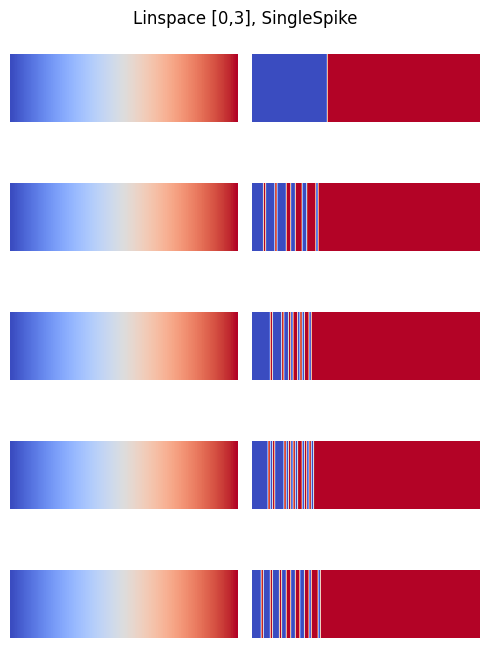

In [114]:
from sinabs.layers import IAF,LIF

import numpy as np

#tensor = torch.rand((1, 2, 34, 34))
#tensor[0,1] = tensor[0,0]
begin = 0
end = 3
tensor = torch.linspace(begin, end, steps=100).repeat(30, 1)
iaf = IAF(spike_fn = spikegen.SingleSpike, record_states=True)

t = 5

image = tensor.unsqueeze(0)
image = torch.stack([image] * t, dim=1)

title = f'Linspace [{begin},{end}], {get_class_name(str(iaf.spike_fn))}'

# image[0, 1:3] = torch.zeros((30, 100))
# image[0, 3] = torch.zeros((30, 100))
# title += ', with interruptions'
#image = sample_data[10].unsqueeze(0).cpu()
print(image.shape)
fig, ax = plt.subplots(image.shape[1], 2, figsize=(5,7))
for i in range(image.shape[1]):
    with torch.no_grad():
        plot_tensor(image[0,i], ax[i,0])
        plot_tensor(iaf(image)[0,i], ax[i, 1])


plt.tight_layout()
fig.suptitle(title)
plt.show()


In [115]:
recordings = iaf.recordings['v_mem']
x = 30
y = 0
print(recordings.shape)
print(image[0, 0, y, x])
for i in range(recordings.shape[1]):
    print(f'{float(image[0,i,y,x]):.4f} -> {float(recordings[0,i,y,x]):.4f}')


torch.Size([1, 5, 30, 100])
tensor(0.9091)
0.9091 -> 0.0909
0.9091 -> 0.0000
0.9091 -> 0.9091
0.9091 -> 0.8182
0.9091 -> 0.7273


In [18]:
def conv_layer(x: 'np.ndarray[np.float32]', W):
    C_in = W.shape[1]
    C_out = W.shape[0]
    kernel_size = tuple((W.shape[2:4]))
    stride = 1
    padding = (1,1)
    # Zero pad
    data_padded = torch.zeros(x.shape[0],
                              x.shape[1] + 2*padding[0],
                              x.shape[2] + 2*padding[0])
    data_padded[:, padding[0]:x.shape[1] + padding[0], padding[1]:x.shape[2] + padding[1]] = x.cpu()
    output = torch.zeros(C_out, x.shape[1], x.shape[2])
    
    coordinate_pairs = [(a, b) for a in range(0, x.shape[1], stride) for b in range(0, x.shape[2], stride)]
    for l in range(C_out):
        for k in range(C_in):
            kernel = W[l,k]
            for i, j in coordinate_pairs:
                i_pad = i + padding[0]
                j_pad = j + padding[1]
                for m_ in range(kernel_size[0]):
                    m = m_ - 1
                    for n_ in range(kernel_size[1]):
                        n = n_ -1
                        output[l, i, j] += (kernel[m_, n_]
                                            * data_padded[k, i_pad + m, j_pad + n])

    return output


x = torch.ones([2, 34, 34])
# sample_data.to('cpu')
# x = sample_data[0].to('cpu')
conv_theirs = conv(x)
conv_mine = conv_layer(x, W)



In [19]:
precision = 5
mine_round = torch.round(conv_mine * 10**precision) / 10**precision
theirs_round = torch.round(conv_theirs * 10**precision) / 10**precision
num_true = torch.sum(mine_round == theirs_round).item()
num_false = (mine_round==theirs_round).numel() - num_true
print(f'True: {num_true}, False: {num_false}')
false_indexes = torch.nonzero((conv_mine == conv_theirs) == False, as_tuple=False)
print(conv_theirs[0,0,0])
print(conv_mine[0,0,0])


True: 9248, False: 0
tensor(0.6782, grad_fn=<SelectBackward0>)
tensor(0.6782, grad_fn=<SelectBackward0>)


In [20]:
weights_np = W.detach().numpy() 
theirs_np = conv_theirs.detach().numpy()
mine_np = conv_mine.detach().numpy()

np.save('./weights/conv-weights.npy', weights_np)
np.save('./tensors/conv-theirs.npy', theirs_np)
np.save('./tensors/conv-mine.npy', mine_np)

In [21]:
conv_mine.reshape(1, 1, 8, 34, 34).shape


torch.Size([1, 1, 8, 34, 34])

In [22]:
class if_layer:
    def __init__(self, input_shape):
        self.membrane = torch.zeros(input_shape)
        self.coordinate_pairs = [(a, b) for a in range(input_shape[1]) for b in range(input_shape[2])]
        self.v_th = 1.0
        
    def reset(self):
        self.membrane = torch.zeros(input_shape)
    def __call__(self, x: 'np.ndarray[np.float32]'):
        '''Basic implementation of IF layer.
        Assumptions:
        spike_threshold = 1.0,
        spike_fn = SingleSpike
        No batch, No timing: the FPGA simply runs everything on FIFO basis
        Thererofe, this has to be a class.
        x dimensions: [c, y, x]
        '''
        output = torch.zeros(self.membrane.shape)
        for c in range(x.shape[0]):
            for (i, j) in self.coordinate_pairs:
                self.membrane[c, i, j] +=  x[c, i, j]

                if self.membrane[c, i, j] > self.v_th:
                    output[c,i,j] = 1;
                    self.membrane[c, i, j] -= 1

        return output


In [23]:
my_if = if_layer(conv_mine.shape)
iaf = IAF(spike_fn = spikegen.SingleSpike)

ifs_mine = [my_if(conv_mine) for _ in range(10)]
ifs_theirs = [iaf(conv_mine.reshape(1,1,8,34,34)) for _ in range(10)]

for i in range(10):
    print(f'{torch.nonzero(ifs_mine[i]).shape[0]} -> ', end='')
print()

for i in range(10):
    print(f'{torch.nonzero(ifs_theirs[i]).shape[0]} -> ', end='')
 print()


1057 -> 5512 -> 1419 -> 6566 -> 2509 -> 4521 -> 2411 -> 6631 -> 2410 -> 4489 -> 
1057 -> 5512 -> 1419 -> 6566 -> 2509 -> 4521 -> 2411 -> 6631 -> 2410 -> 4489 -> 


In [41]:
if_torch_np[0,0,0,0]

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [42]:
if_torch_np = ifs_theirs[0].detach().numpy()
np.save('./tensors/if-torch.npy', if_torch_np)

In [221]:
lel = modules[1](modules[0](torch.ones([2, 34, 34]))
           )


In [228]:
def avg_pool2d(x):
    kernel = (2,2)
    stride = 2
    padding = 0

    # Create output buffer
    H_out = math.floor((x.shape[1] + (2 * padding) - kernel[0]) / stride) + 1
    W_out = math.floor((x.shape[2] + (2 * padding) - kernel[0]) / stride) + 1
    output = torch.zeros((x.shape[0], H_out, W_out))

    # Zero pad
    data_padded = torch.zeros(x.shape[0],
                              x.shape[1] + 2*padding,
                              x.shape[2] + 2*padding)
    data_padded[:, padding:x.shape[1] + padding, padding:x.shape[2] + padding] = x.cpu()

    coordinate_pairs = [(a, b) for a in range(H_out) for b in range(W_out)]
    coordinate_pairs.sort()
    kernel_pairs = [(a, b) for a in range(kernel[0]) for b in range(kernel[1])]
    kernel_pairs.sort()
    for c in range(output.shape[0]):
        for (h, w) in coordinate_pairs:
            # Apply kernel
            kernel_sum = 0
            for (m, n) in kernel_pairs:
                kernel_sum += data_padded[c, stride * h + m, stride * w + n]
            output[c, h, w] = 1 / (kernel[0] * kernel[1]) * kernel_sum

    return output                         

In [231]:
x = ifs_mine[0]
pool = nn.AvgPool2d(2, 2)

pool_mine = avg_pool2d(x)
pool_torch = pool(x.unsqueeze(0))

precision = 5
mine_round = torch.round(pool_mine * 10**precision) / 10**precision
torch_round = torch.round(pool_torch * 10**precision) / 10**precision
num_true = torch.sum(mine_round == torch_round).item()
num_false = (mine_round==torch_round).numel() - num_true
print(f'True: {num_true}, False: {num_false}')
#false_indexes = torch.nonzero((pool_mine == pool_torch) == False, as_tuple=False)


True: 2312, False: 0


In [237]:
pool_torch_np = pool_torch.detach().numpy()
pool_mine_np = pool_mine.detach().numpy()

np.save('./tensors/pool-torch.npy', pool_torch_np)
np.save('./tensors/pool-mine.npy', pool_mine_np)

torch.Size([1, 2, 34, 34])

In [345]:
x = sample_data.cpu()
saved_x = x.detach().numpy()
np.save('./tensors/sample-data.npy', saved_x)
saved_x.shape

(100, 2, 34, 34)

In [349]:
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')
with torch.no_grad():
    saved_output = snn(x.squeeze(0))

np.save('./tensors/output.npy', saved_output)
saved_output.shape

torch.Size([100, 10])

In [398]:
def get_module_name(input_string):
    input_string = str(input_string)
    # Pattern to match the function name and contents within first
    pattern = r"^([a-zA-Z_][a-zA-Z0-9_]*)\(.*"
    
    match = re.match(pattern, input_string)
    if match:
        return match.group(1)  # Return the function name
    else:
        return None  # If there's no match

In [459]:
snn = from_model(model=model, input_shape=(2, 34, 34), batch_size=1, spike_fn=spikegen.SingleSpike).spiking_model.to('cpu')

lin = None
stop = 10
name = None
data = x
with torch.no_grad():
    for (i, m) in enumerate(list(snn.modules())[1:]):
        mod_name = get_module_name(m)
        if i == stop:
            print(f'Stopping at {i} - {mod_name}')
            break
        print(f'Doing {i} - {mod_name}')
       
        if (mod_name == 'Conv2d') or mod_name == 'Linear':
            save_name = f'./weights/{i}-{mod_name}.npy'
            np.save(save_name, list(m.parameters())[0])
            print(f'\tSaved weights {save_name} : {data.shape}')

        if mod_name == 'Linear':
            lin = m

        if mod_name == 'IAFSqueeze':
            m.record_states = True

        data = m(data)
        if mod_name == 'IAFSqueeze':
            save_name = f'./tensors/recording-{i}-{mod_name}.npy'
            np.save(save_name, m.recordings['v_mem'].squeeze())
            print(f'\tSaved recordings {save_name} : {data.shape}')
        name = mod_name

save_name = f'./tensors/output-{i-1}-{name}.npy'
np.save(save_name, data)
print(f'Saved {save_name} : {data.shape}')

Doing 0 - Conv2d
	Saved weights ../src/c-snn/weights/0-Conv2d.npy : torch.Size([100, 2, 34, 34])
Doing 1 - IAFSqueeze
	Saved recordings ../src/c-snn/tensors/recording-1-IAFSqueeze.npy : torch.Size([100, 8, 34, 34])
Doing 2 - AvgPool2d
Doing 3 - Conv2d
	Saved weights ../src/c-snn/weights/3-Conv2d.npy : torch.Size([100, 8, 17, 17])
Doing 4 - IAFSqueeze
	Saved recordings ../src/c-snn/tensors/recording-4-IAFSqueeze.npy : torch.Size([100, 16, 17, 17])
Doing 5 - AvgPool2d
Doing 6 - Conv2d
	Saved weights ../src/c-snn/weights/6-Conv2d.npy : torch.Size([100, 16, 8, 8])
Doing 7 - IAFSqueeze
	Saved recordings ../src/c-snn/tensors/recording-7-IAFSqueeze.npy : torch.Size([100, 16, 4, 4])
Doing 8 - Flatten
Doing 9 - Linear
	Saved weights ../src/c-snn/weights/9-Linear.npy : torch.Size([100, 256])
Doing 10 - IAFSqueeze
	Saved recordings ../src/c-snn/tensors/recording-10-IAFSqueeze.npy : torch.Size([100, 10])
Saved ../src/c-snn/tensors/output-9-IAFSqueeze.npy : torch.Size([100, 10])


In [463]:
linx = torch.ones((256,))
lin(linx)

tensor([-2.6361,  2.3727,  3.0525,  2.6921, -1.6624, -0.8216, -0.1405, -0.8961,
        -3.1682, -2.8986], grad_fn=<SqueezeBackward4>)

In [423]:
def getIndex(dims, shape):
    v_index = dims[0];
    for i in range(1, len(dims), 1):
        v_index = v_index * shape[i] + dims[i]
    return v_index

In [442]:
golden = [5,11,15]
getIndex(golden, [8, 34, 34])

6169

In [458]:
print('hi')

hi
